In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
from mini_yolov3.model import MiniYoloV3
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from mini_yolov3.evals import calculate_mAP
from torchvision.ops import box_iou
from tqdm import tqdm

In [64]:
train_dataset = SVHNDataset(split="train")
# train_dataset = Subset(train_dataset, range(12, 13))
train_dataset = Subset(train_dataset, range(0, 2))

In [65]:
train_dataset[0]["bbox"]

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

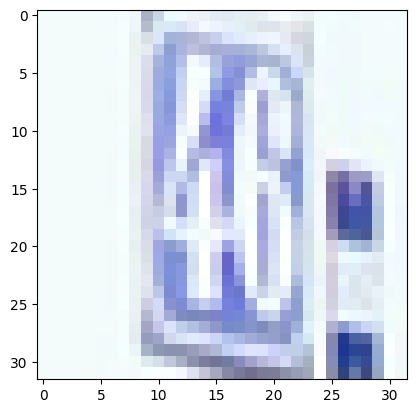

In [66]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

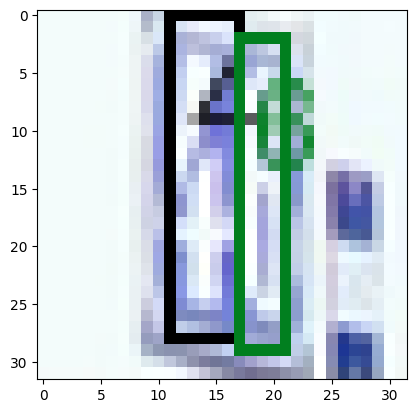

In [67]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [70]:
dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [71]:
len(dataloader)

1

In [72]:
for batch in dataloader:
    print(batch["bboxes"])
    print(box_convert(batch["bboxes"][0], "xywh", "cxcywh"))
    targets = build_targets(batch["bboxes"], batch["labels"], (2, 2), anchors, 10)

[tensor([[0.3443, 0.1290, 0.1967, 0.7419],
        [0.5082, 0.1613, 0.1639, 0.7419]]), tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])]
tensor([[0.4426, 0.5000, 0.1967, 0.7419],
        [0.5902, 0.5323, 0.1639, 0.7419]])


NameError: name 'anchors' is not defined

In [73]:
batch["images"].shape

torch.Size([2, 3, 32, 32])

In [74]:
import json

In [96]:
torch.manual_seed(0)

config = json.load(open("./configs/experiment.json", "r"))
model = MiniYoloV3(**config)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    num_epochs=250,
    lr=3e-3,
    batch_size=64,
    lambda_coord=1,
    lambda_noobj=1,
    device="cpu",
    eval_every=100000,
)

100%|██████████| 250/250 [00:39<00:00,  6.30it/s, class_loss=0.00487, conf_loss=0.0142, coord_loss=1.87e-5, loss=0.0191] 


[46.000831604003906,
 37.088523864746094,
 33.30764389038086,
 29.196359634399414,
 26.999588012695312,
 25.37957191467285,
 23.671573638916016,
 22.2258243560791,
 21.04848861694336,
 19.99712371826172,
 19.019432067871094,
 18.094240188598633,
 17.21121597290039,
 16.370986938476562,
 15.574708938598633,
 14.822559356689453,
 14.113785743713379,
 13.441906929016113,
 12.803974151611328,
 12.183801651000977,
 11.58375072479248,
 11.002578735351562,
 10.438810348510742,
 9.89075756072998,
 9.356911659240723,
 8.836677551269531,
 8.329904556274414,
 7.836747646331787,
 7.357583999633789,
 6.893808841705322,
 6.447819709777832,
 6.022231101989746,
 5.618785858154297,
 5.237748622894287,
 4.878350257873535,
 4.539480686187744,
 4.220035552978516,
 3.9190421104431152,
 3.635525941848755,
 3.368540048599243,
 3.117408275604248,
 2.8816215991973877,
 2.6607398986816406,
 2.454294443130493,
 2.2618584632873535,
 2.083127021789551,
 1.9179437160491943,
 1.7660934925079346,
 1.6272590160369873,

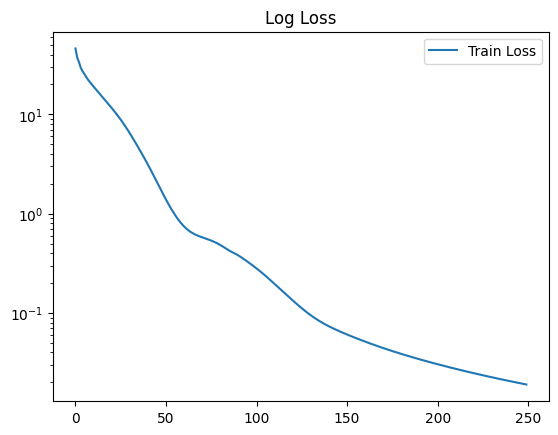

In [97]:
trainer.train()

In [98]:
pred = model(batch["images"])
pred.shape

torch.Size([2, 4, 4, 30])

In [99]:
pred[0, 0, 0, :], pred[0, 1, 1, :]

(tensor([-0.3142, -0.5777,  0.3441, -0.3687, -4.3410,  0.0883,  0.0684, -0.1960,
          0.3697, -0.1435,  0.1860,  0.0472,  0.1070, -0.1844, -0.1655, -0.0328,
          1.1753,  0.5484, -0.1068, -4.5080, -0.4270, -1.0316, -1.0651, -0.9044,
          0.5508, -1.0201, -1.3743, -0.0142, -0.6574, -0.7117],
        grad_fn=<SliceBackward0>),
 tensor([ 6.0586e-02, -5.5696e-01,  1.5347e-01,  3.4252e-02, -4.6875e+00,
         -1.4023e-02,  2.6941e-01, -1.9420e-01,  5.3746e-01, -4.5516e-01,
         -2.0648e-01, -3.0404e-02, -5.2434e-02, -1.9806e-01, -2.7937e-05,
         -1.1335e-01,  1.1814e+00,  2.7766e-01,  1.5485e-01, -4.0093e+00,
         -8.7483e-01, -1.1758e+00, -1.4727e+00, -8.5215e-01,  1.1929e+00,
         -9.0605e-01, -9.5823e-01, -5.1779e-01, -8.5308e-01, -9.6419e-01],
        grad_fn=<SliceBackward0>))

In [104]:
i = 0

In [105]:
output = model.inference(
    batch["images"],
)

bounding_boxes = output.bboxes
bounding_boxes

[{'bboxes': tensor([[0.4425, 0.5000, 0.1966, 0.7418],
          [0.5902, 0.5321, 0.1639, 0.7424]]),
  'confidence': tensor([0.9870, 0.9799]),
  'labels': tensor([7, 1]),
  'scores': tensor([0.9934, 0.9974])},
 {'bboxes': tensor([[0.6076, 0.5000, 0.1497, 0.8696],
          [0.4532, 0.4567, 0.1963, 0.8692]]),
  'confidence': tensor([0.9986, 0.9434]),
  'labels': tensor([6, 4]),
  'scores': tensor([0.9943, 0.9956])}]

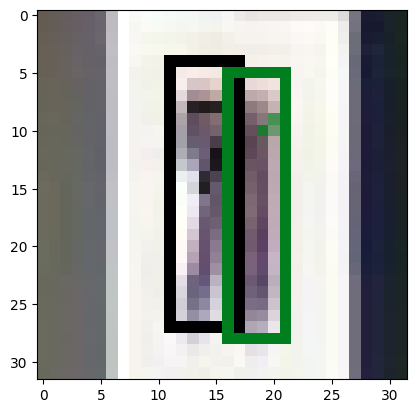

In [106]:
plt.imshow(
    draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
)
)

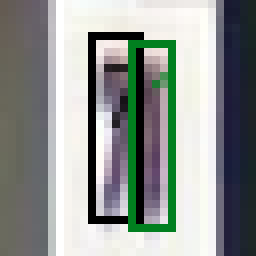

In [107]:
draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
).resize((256, 256), 0)

In [83]:
calculate_mAP(
    model,
    trainer.train_loader,
)

100%|██████████| 1/1 [00:00<00:00, 52.11it/s]


{'map': 1.0,
 'map_50': 1.0,
 'map_75': 1.0,
 'map_small': 1.0,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 1.0,
 'mar_10': 1.0,
 'mar_100': 1.0,
 'mar_small': 1.0,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': [1, 4, 6, 7]}